In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import math
from sklearn import mixture
from skimage import data, segmentation, color
from sklearn.cluster import KMeans

In [58]:
# import the training image and validation datasets
base_imgs = []
validation_imgs = []
base_imgs_filenames = glob.glob("./flower_segmentation/images/*.jpg")
validation_imgs_filenames = glob.glob("./flower_segmentation/segmentation/*.png")

for i in base_imgs_filenames:
    image = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
    base_imgs.append(image)
    
for i in validation_imgs_filenames:
    image = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
    validation_imgs.append(image)

vali_gscaled = [cv2.cvtColor(vali_img, cv2.COLOR_RGB2GRAY) for vali_img in validation_imgs]
vali_gscaled = [np.where(vali_img == 255, 1, 0) for vali_img in vali_gscaled]

# show the first image from the training and the validation set
plt.subplot(121), plt.imshow(base_imgs[0])
plt.title(""), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(validation_imgs[0])
plt.title(""), plt.xticks([]), plt.yticks([])
plt.show()

[1 1 1 ... 1 1 1]
(265500,)


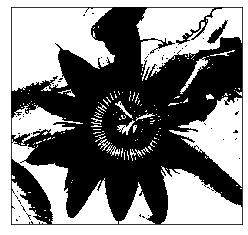

In [59]:
# Reshape image
img = base_imgs[0]
reshaped = img.reshape((-1, 3))

# Compute the gaussian mixture object as per the parameters listed
gm = mixture.GaussianMixture(n_components = 2, covariance_type = 'spherical',
                                n_init = 1, init_params = "kmeans")

# Show labels and labelled image, to verify if the method works
labels = gm.fit_predict(reshaped)
print(labels)
print(labels.shape)

plt.imshow(labels.reshape((500, 531)), cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

In [60]:
# Function to segment images given a list of images and parameters
# performs the same operations to images as per the cell above
def segment_imgs(base_imgs, covar_type, tolerance, inits):
    segmented_imgs = []
    gm = mixture.GaussianMixture(n_components = 2, covariance_type = covar_type,
                                 tol = tolerance, n_init = inits, init_params = "kmeans")
    for img in base_imgs:
        labels = gm.fit_predict(img.reshape((-1, 3)))
        segmented_imgs.append(labels.reshape((img.shape[0], img.shape[1])))
    return segmented_imgs

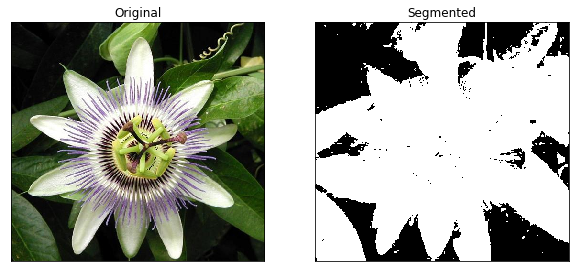

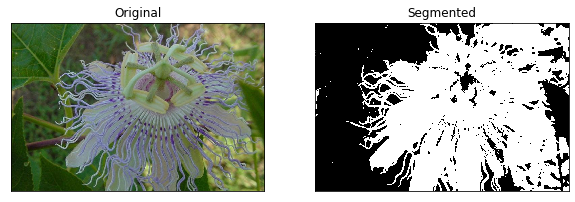

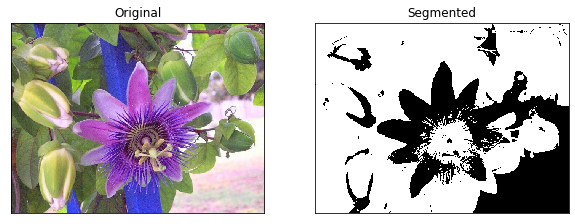

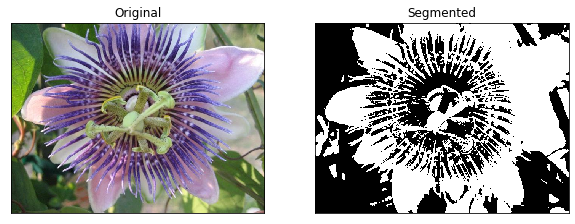

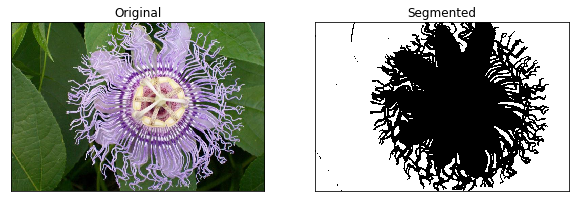

In [61]:
# Plot out the first five segmented and training set images
segmented_imgs = segment_imgs(base_imgs, 'full', 1e-3, 1) 
for i in range(5): 
    plt.figure(figsize = (10, 5)) 
    plt.subplot(121), plt.imshow(base_imgs[i]) 
    plt.title("Original"), plt.xticks([]), plt.yticks([]) 
    plt.subplot(122), plt.imshow(segmented_imgs[i], cmap = "gray") 
    plt.title("Segmented"), plt.xticks([]), plt.yticks([]) 
    plt.show()

In [70]:
# Function to evaluate the Kmeans segmentation given an image
def Kmeans(img):
    
    # reshape image
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 15, 1.0)
    K = 3
    ret,label,center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # evaluate labels based on segments
    labels = segmentation.slic(img, compactness=0.1, n_segments=2)
    
    return labels

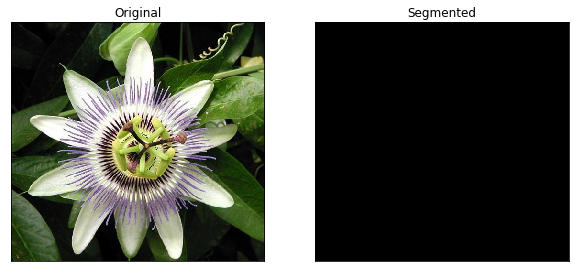

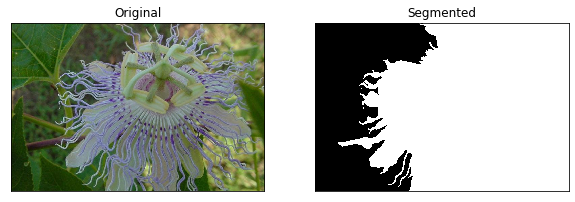

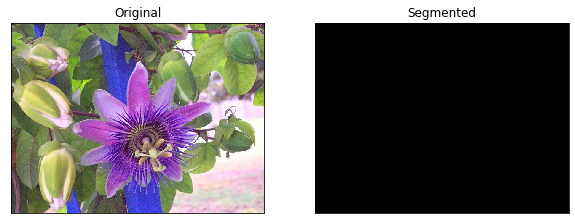

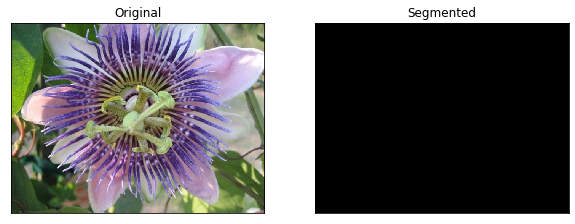

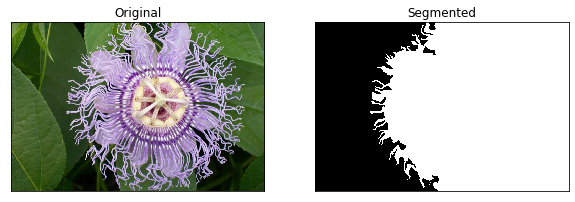

In [71]:
# Apply the Kmeans segmentation to each training set image and add to a list
kmeans_imgs = []
for img in base_imgs:
    output = Kmeans(img)
    kmeans_imgs.append(output)

# Plot out the first five segmented and training set images
for i in range(5): 
    plt.figure(figsize = (10, 5)) 
    plt.subplot(121), plt.imshow(base_imgs[i]) 
    plt.title("Original"), plt.xticks([]), plt.yticks([]) 
    plt.subplot(122), plt.imshow(kmeans_imgs[i], cmap = "gray") 
    plt.title("Segmented"), plt.xticks([]), plt.yticks([]) 
    plt.show()

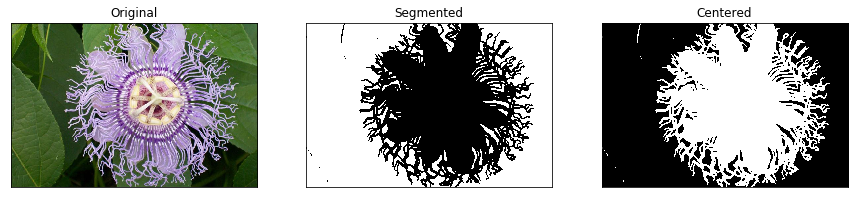

In [64]:
# To ensure that the correct segments of the image are white (flower) and black (background), implement a function
# that calculates the standard deviation of the segmented images to determine which label becomes b/w
def zero_center(seg_img):
    
    # Comparing positions throughout the image, groupings with a smaller 
    # standard deviation are set to white (flower)
    avg0pos = np.mean(np.where(seg_img == 0), axis = 1)
    stdev0pos = np.linalg.norm(np.mean((np.where(seg_img == 0) - avg0pos.reshape(2, 1)) ** 2, axis = 1) ** 0.5)
    avg1pos = np.mean(np.where(seg_img == 1), axis = 1)
    stdev1pos = np.linalg.norm(np.mean((np.where(seg_img == 1) - avg1pos.reshape(2, 1)) ** 2, axis = 1) ** 0.5)
    
    # Checking to see which of the total std dev between the positions are larger, if label colors are swapped
    # the image's colors are inversed
    if (stdev1pos > stdev0pos):
        seg_img = 1 - seg_img
    return seg_img

# Apply the function above to all the segmented images    
def center_list(seg_imgs):
    return [zero_center(img) for img in seg_imgs]

centered_imgs = center_list(segmented_imgs)
kcentered_imgs = center_list(kmeans_imgs)

# Plot images, shows how the centering function recolors labels if necessary for EM
for i in range(5):
    plt.figure(figsize = (15, 5))
    plt.subplot(131), plt.imshow(base_imgs[i])
    plt.title("Original"), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(segmented_imgs[i], cmap = "gray")
    plt.title("Segmented"), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(centered_imgs[i], cmap = "gray")
    plt.title("Centered"), plt.xticks([]), plt.yticks([])
    plt.show()

In [79]:
kcentered_imgs = center_list(kmeans_imgs)

# Plot out the recentered segmented images for the Kmeans algorithm
# for i in range(5):
  # plt.figure(figsize = (15, 5))
  # plt.subplot(131), plt.imshow(base_imgs[i])
  # plt.title("Original"), plt.xticks([]), plt.yticks([])
  # plt.subplot(132), plt.imshow(kmeans_imgs[i], cmap = "gray")
  # plt.title("Segmented"), plt.xticks([]), plt.yticks([])
  # plt.subplot(133), plt.imshow(kcentered_imgs[i], cmap = "gray")
  # plt.title("Centered"), plt.xticks([]), plt.yticks([])
  # plt.show()

C:\Users\tyler\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\tyler\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [73]:
# Function to gather cross validation statistics, ie. DSC and accuracy
def cross_validation(seg_imgs, k):
    dice_results = []
    acc_results = []
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    # Determines parameters based on labelled values
    for i in range(len(seg_imgs)):
        TP += np.where(np.logical_and(seg_imgs[i] == 1, vali_gscaled[i] == 1))[0].shape[0]
        TN += np.where(np.logical_and(seg_imgs[i] == 0, vali_gscaled[i] == 0))[0].shape[0]
        FP += np.where(np.logical_and(seg_imgs[i] == 1, vali_gscaled[i] == 0))[0].shape[0]
        FN += np.where(np.logical_and(seg_imgs[i] == 0, vali_gscaled[i] == 1))[0].shape[0]
        
        # Perform calculation for multiples of k as per section 6.1.1 and 6.1.4
        if ((i + 1) % k == 0):
            dice_results.append(2 * TP / (2 * TP + FN + FP))
            acc_results.append((TP + TN) / (TP + TN + FP + FN))
        
            TP = 0
            TN = 0
            FP = 0
            FN = 0
            
    return dice_results, acc_results

EM Mean DSC: 0.8222986469637711
EM Std Dev DSC: 0.11911990333261156
EM Max DSC: 0.9630091380128722
EM Min DSC: 0.4964714653937757
-----
Kmeans Mean DSC: 0.5868486254960549
Kmeans Std Dev DSC: 0.22922943724874498
Kmeans Max DSC: 0.907367494806721
Kmeans Min DSC: 0.0


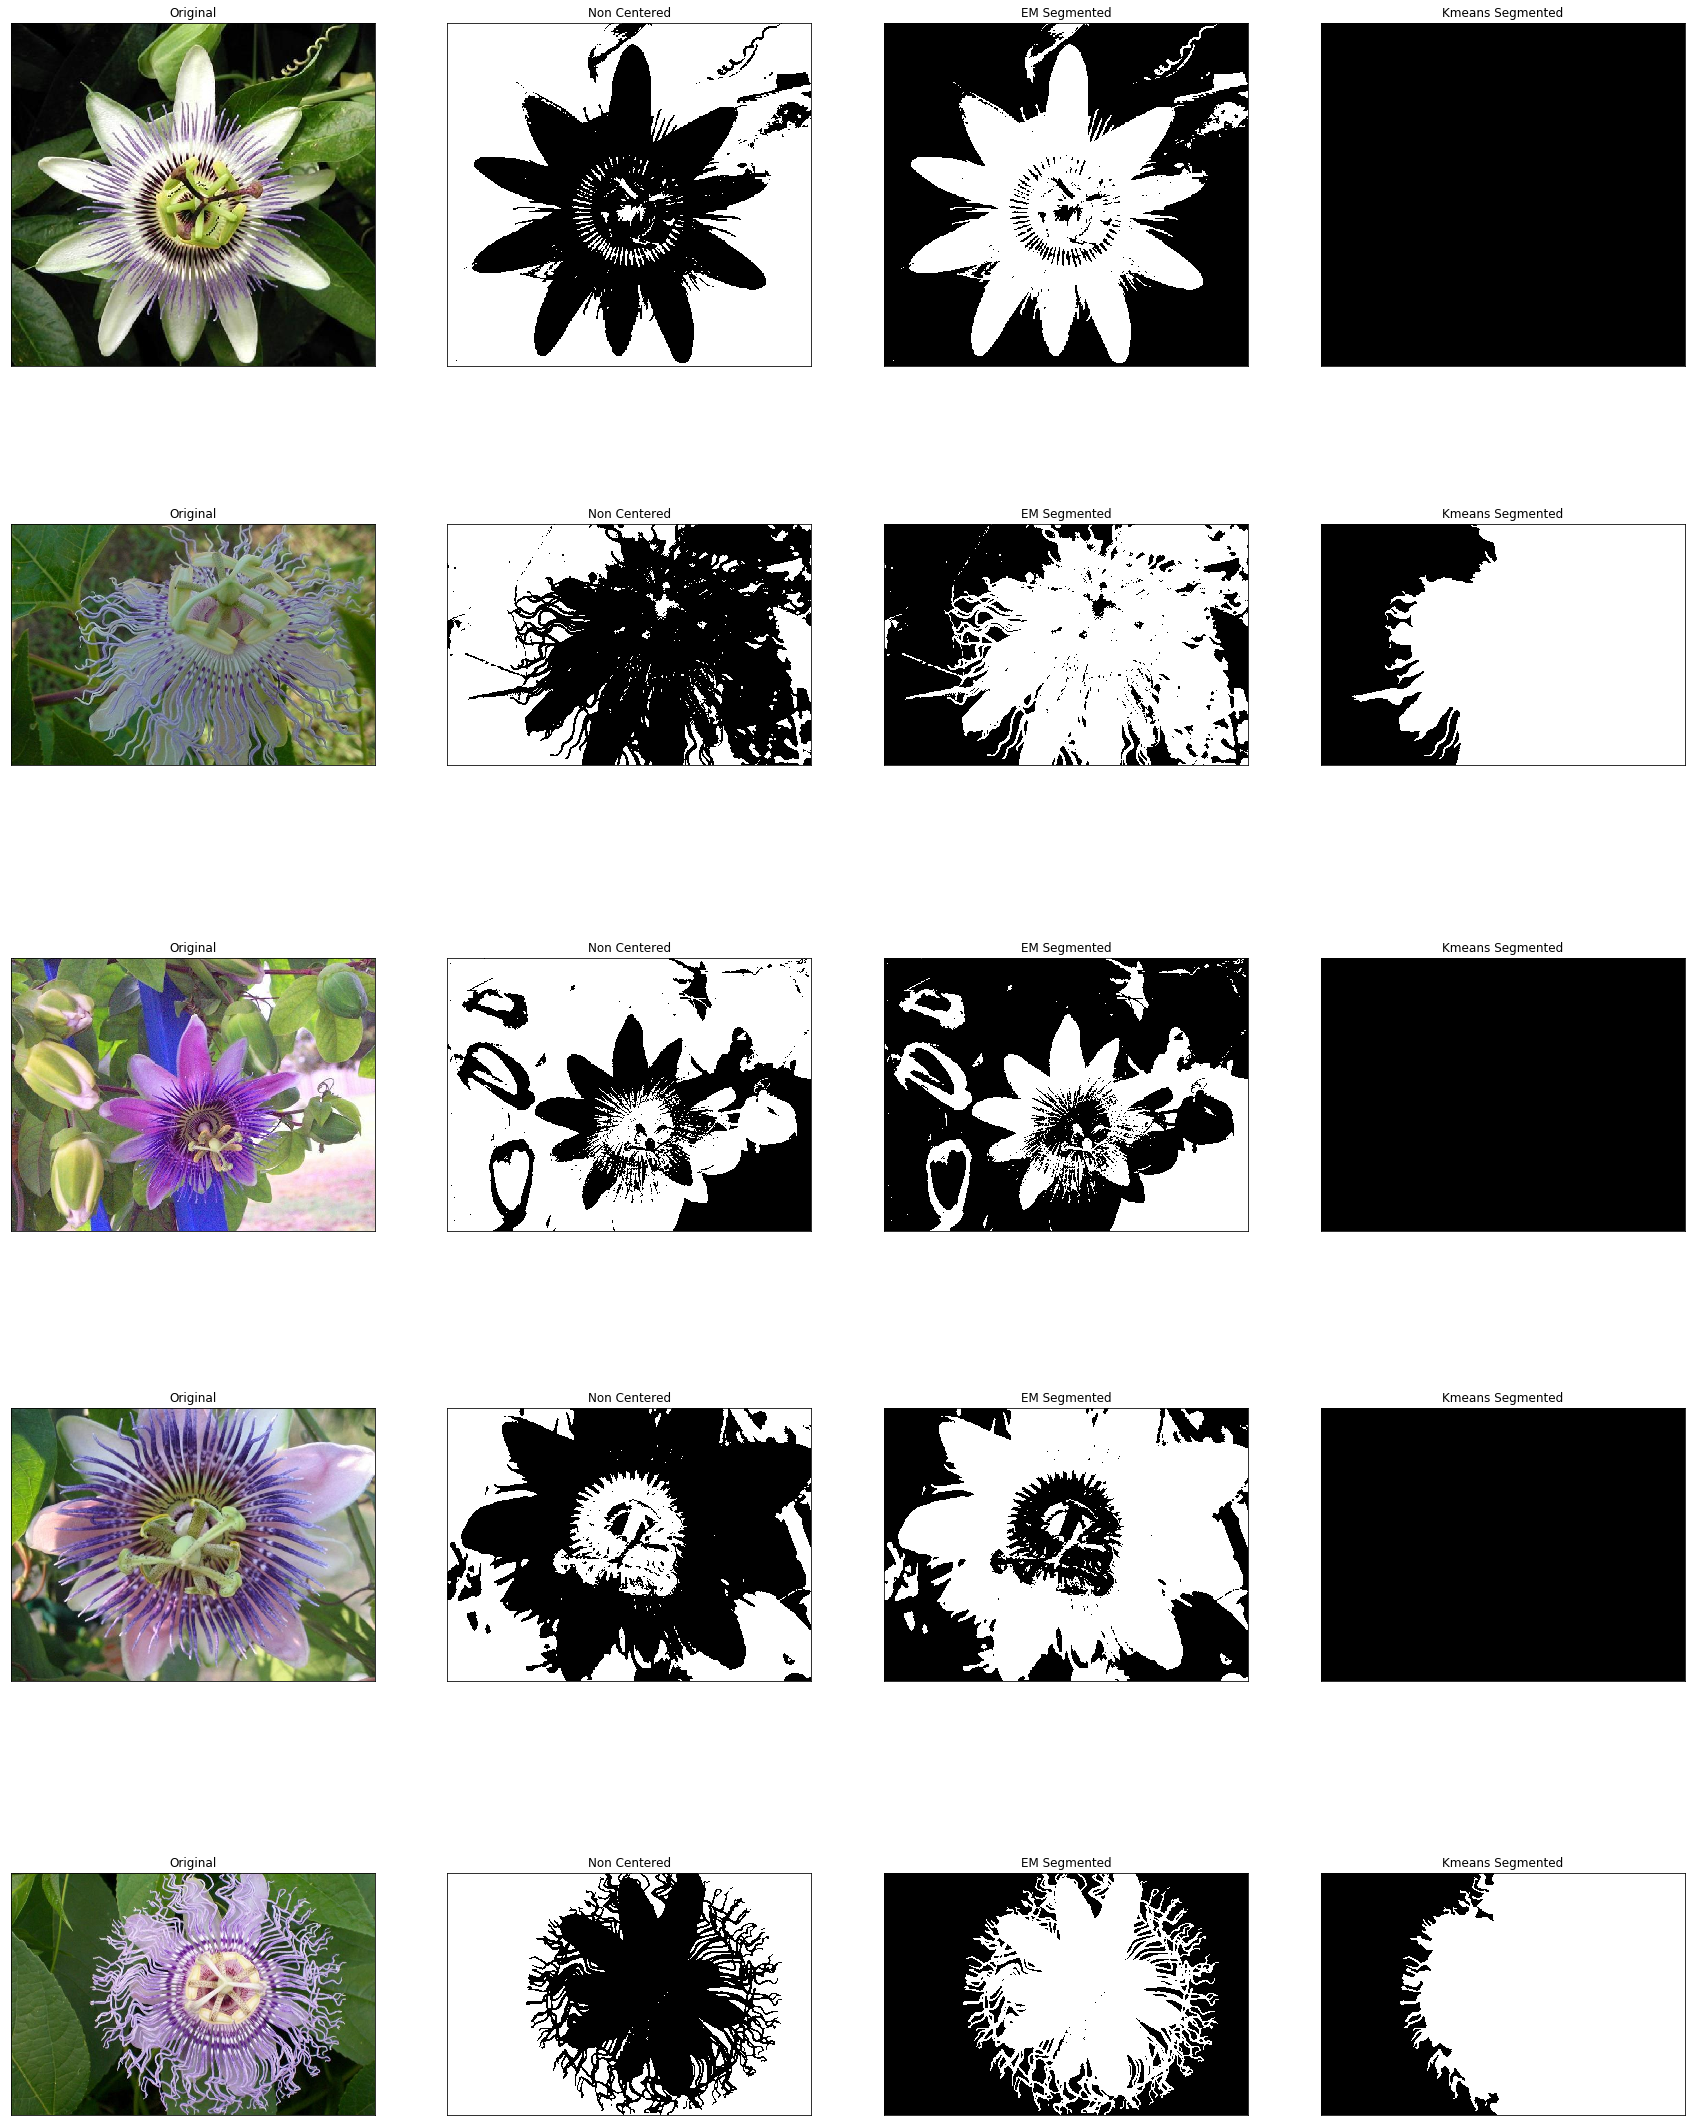

In [80]:
# Print out statistics from the cross validation
segmented_imgs = segment_imgs(base_imgs, 'tied', 1e-4, 3)
centered_imgs = center_list(segmented_imgs)

dice_em, acc_em = cross_validation(centered_imgs, 5)
dice_k, acc_k = cross_validation(kcentered_imgs, 5)

print("EM Mean DSC:", np.mean(dice_em))
print("EM Std Dev DSC:", np.std(dice_em))
print("EM Max DSC:", np.amax(dice_em))
print("EM Min DSC:", np.amin(dice_em))
print("-----")
print("Kmeans Mean DSC:", np.mean(dice_k))
print("Kmeans Std Dev DSC:",np.std(dice_k))
print("Kmeans Max DSC:",np.amax(dice_k))
print("Kmeans Min DSC:",np.amin(dice_k))

# Plot out final segmented images for EM
plt.figure(figsize = (30, 40))
for i in range(5):
    plt.subplot(5, 4, (i * 4) + 1), plt.imshow(base_imgs[i])
    plt.title("Original"), plt.xticks([]), plt.yticks([])
    plt.subplot(5, 4, (i * 4) + 2), plt.imshow(segmented_imgs[i], cmap = "gray")
    plt.title("Non Centered"), plt.xticks([]), plt.yticks([])
    plt.subplot(5, 4, (i * 4) + 3), plt.imshow(centered_imgs[i], cmap = "gray")
    plt.title("EM Segmented"), plt.xticks([]), plt.yticks([])
    plt.subplot(5, 4, (i * 4) + 4), plt.imshow(kmeans_imgs[i], cmap = "gray")
    plt.title("Kmeans Segmented"), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
def possible_args(): 
    opts = [] 
    covar_types = ['full', 'tied', 'diag', 'spherical'] 
    tolerances = [1e-2, 1e-3, 1e-4, 1e-5] 
    n_inits = [1, 2, 5] 
    for cov in covar_types: 
        for toler in tolerances: 
            for ini in n_inits: 
                opts.append(dict(n_components = 2, covariance_type = cov, tol = toler, n_init = ini)) 
    return opts 
# print(possible_args()) 

bestdice = 0 
bestargs = None 
for args in possible_args(): 
    print(args) 
    segmented_imgs = [] 
    for img in base_imgs: 
        gm = mixture.GaussianMixture(**args) 
        labels = gm.fit_predict(img.reshape((-1, 3))) 
        segmented_imgs.append(labels.reshape((img.shape[0], img.shape[1]))) 
        centered_imgs = center_list(segmented_imgs) 
        dice = cross_validation(centered_imgs,1) 
        print(dice) 
        if dice > bestdice: 
            bestdice = dice 
            bestargs = args 
            print('-------------------------------------------') 
            print('Best DICE:') 
            print(bestdice) 
            print(bestargs)